## 0.前準備

各種ライブラリのインポート

In [115]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.9 MB 11.2 MB/s eta 0:00:01
You should consider upgrading via the '/Users/saitokoshi/Documents/Kaggle/titanic-survived-prediction/.venv/bin/python3 -m pip install --upgrade pip' command.


In [116]:
import numpy as np
import pandas as pd
import os
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from lightgbm import LGBMClassifier
import xgboost as xgb
import optuna
import shap

In [3]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/test.csv
input/train.csv
input/gender_submission.csv


ランダムシードの設定

In [4]:
np.random.seed(42)
random.seed(42)

## 1.データの読み込み

In [5]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
gender_submission_df = pd.read_csv('input/gender_submission.csv')

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
gender_submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 2.探索的データ解析(EDA)

### 2.1.データの情報確認

In [9]:
# データ数の確認(shape)
print(f'train data: {train_df.shape}')
print(f'test data: {test_df.shape}')

train data: (891, 12)
test data: (418, 11)


object型のデータは，Name, Sex, Ticket, Cabin, Embarked

In [10]:
# データの型を確認(info)
print(train_df.info(),'\n')
print(test_df.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   P

In [11]:
# データの統計量を確認(describe)
print(train_df.describe(),'\n')
print(test_df.describe(),'\n')

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200   

       PassengerId      Pclass         Age       SibSp       Parch        Fare


In [12]:
# 'Name'列を除いてobject型の列についてvalue_countsを表示
for col in train_df.select_dtypes(include=['object']).columns:
    if col == 'Name':
        continue
    print(f'train {col} value counts:\n{train_df[col].value_counts()}\n')

train Sex value counts:
Sex
male      577
female    314
Name: count, dtype: int64

train Ticket value counts:
Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

train Cabin value counts:
Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

train Embarked value counts:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64



In [13]:
for col in test_df.select_dtypes(include=['object']).columns:
    if col == 'Name':
        continue
    print(f'test {col} value counts:\n{test_df[col].value_counts()}\n')

test Sex value counts:
Sex
male      266
female    152
Name: count, dtype: int64

test Ticket value counts:
Ticket
PC 17608    5
CA. 2343    4
113503      4
PC 17483    3
220845      3
           ..
349226      1
2621        1
4133        1
113780      1
2668        1
Name: count, Length: 363, dtype: int64

test Cabin value counts:
Cabin
B57 B59 B63 B66    3
B45                2
C89                2
C55 C57            2
A34                2
                  ..
E52                1
D30                1
E31                1
C62 C64            1
C105               1
Name: count, Length: 76, dtype: int64

test Embarked value counts:
Embarked
S    270
C    102
Q     46
Name: count, dtype: int64



### 2.2.欠損値の確認

In [14]:
# 欠損値の確認(isnull().sum())
print(f"train_df.isnull().sum()\n{train_df.isnull().sum()}")
print(f"test_df.isnull().sum()\n{test_df.isnull().sum()}")

train_df.isnull().sum()
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
test_df.isnull().sum()
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### 2.3.可視化

#### 2.3.1.Embarkedごとにsurvivalを可視化

In [15]:
train_df[["PassengerId","Survived","Embarked"]].dropna().groupby(by=["Embarked", "Survived"]).count()

PassengerId
Embarked Survived             
C        0                  75
         1                  93
Q        0                  47
         1                  30
S        0                 427
         1                 217

unstackで列に展開

In [16]:
embarked_df = train_df[["PassengerId","Survived","Embarked"]].dropna().groupby(by=["Embarked", "Survived"]).count().unstack()
embarked_df

PassengerId     
Survived           0    1
Embarked                 
C                 75   93
Q                 47   30
S                427  217

In [17]:
print(embarked_df)

         PassengerId     
Survived           0    1
Embarked                 
C                 75   93
Q                 47   30
S                427  217


<Axes: xlabel='Embarked'>

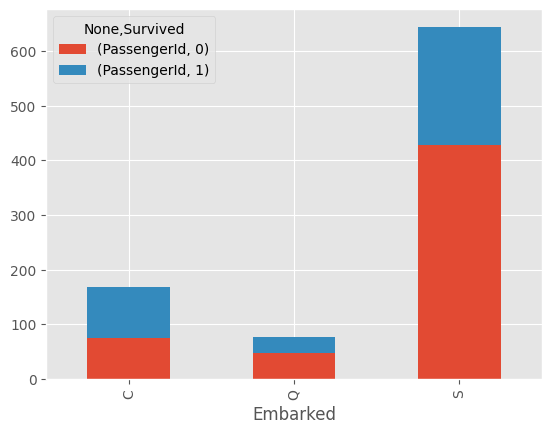

In [18]:
embarked_df.plot.bar(stacked=True)

>##### NOTE:matplotlibの場合

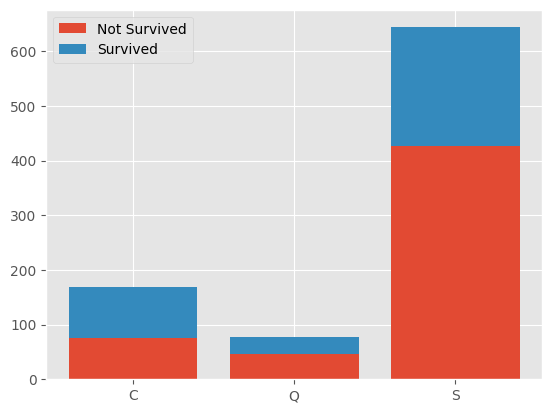

In [19]:
# matplotlibで直接描画
plt.bar(embarked_df.index, embarked_df[("PassengerId", 0)], label="Not Survived")
plt.bar(
    embarked_df.index,
    embarked_df[("PassengerId", 1)],
    bottom=embarked_df[("PassengerId", 0)],
    label="Survived"
)
plt.legend()
plt.show()

>##### NOTE:seabornの場合

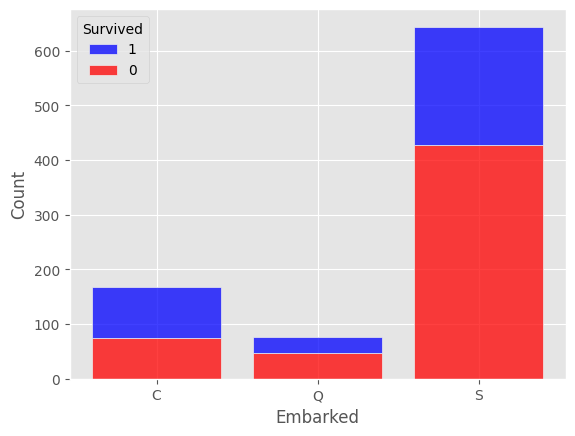

In [20]:
embarked_long = embarked_df["PassengerId"].reset_index().melt(
    id_vars="Embarked",      # 固定する列
    value_vars=[0, 1],       # Survived=0,1
    var_name="Survived",     # 新しい列名
    value_name="Count"       # 値
)

sns.histplot(
    data=embarked_long,
    x="Embarked",
    weights="Count",     # Count列を棒の高さに使う
    hue="Survived",      # 色分け
    hue_order=[1, 0],   # 先に1、その上に0を積む
    multiple="stack",    # 積み上げ
    shrink=0.8,           # 棒の幅を少し細く
    palette={1:"blue", 0:"red"}
)
plt.show()


>##### NOTE:plotlyの場合

In [21]:
import plotly.express as px
# 生存=1を下側、0を上側に積みたいときは category_orders で順序を指定
fig = px.bar(
    embarked_long,
    x="Embarked",
    y="Count",
    color="Survived",
    category_orders={"Survived": [1, 0]},  # 下:1 → 上:0
    color_discrete_map={1: "blue", 0: "red"},  # 色指定（任意）
    barmode="stack"
)
fig.show("browser")

Embarkedごとのsurvived_rateを計算

>##### NOTE:```iloc```でも記述可能   
```python
embarked_df["survived_rate"] = (
    embarked_df.iloc[:, 1] /
    (embarked_df.iloc[:, 0] + embarked_df.iloc[:, 1])
)
```

In [22]:
embarked_df["survived_rate"] = (
    embarked_df.loc[:, ("PassengerId", 1)] /
    (embarked_df.loc[:, ("PassengerId", 0)] + embarked_df.loc[:, ("PassengerId", 1)])
)
embarked_df

PassengerId      survived_rate
Survived           0    1              
Embarked                               
C                 75   93      0.553571
Q                 47   30      0.389610
S                427  217      0.336957

#### 2.3.2.性別ごとにsurvivalを可視化

In [23]:
sex_df = train_df[["PassengerId","Survived","Sex"]].dropna().groupby(by=["Sex", "Survived"]).count().unstack()
sex_df

PassengerId     
Survived           0    1
Sex                      
female            81  233
male             468  109

<Axes: xlabel='Sex'>

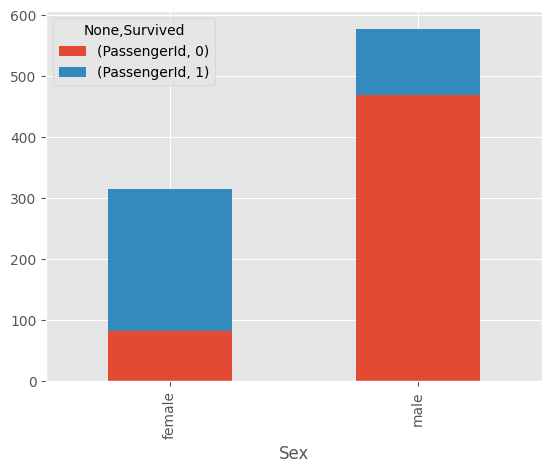

In [24]:
sex_df.plot.bar(stacked=True)

In [25]:
sex_df["survived_rate"] = (
    sex_df.loc[:, ("PassengerId", 1)] /
    (sex_df.loc[:, ("PassengerId", 0)] + sex_df.loc[:, ("PassengerId", 1)])
)
sex_df

PassengerId      survived_rate
Survived           0    1              
Sex                                    
female            81  233      0.742038
male             468  109      0.188908

#### 2.3.3.Pclass(Ticket class)ごとにsurvivalを可視化

In [26]:
pclass_df_long = train_df[["PassengerId","Survived","Pclass"]].dropna().groupby(by=["Pclass", "Survived"]).count()
pclass_df = train_df[["PassengerId","Survived","Pclass"]].dropna().groupby(by=["Pclass", "Survived"]).count().unstack()
pclass_df

PassengerId     
Survived           0    1
Pclass                   
1                 80  136
2                 97   87
3                372  119

<Axes: xlabel='Pclass'>

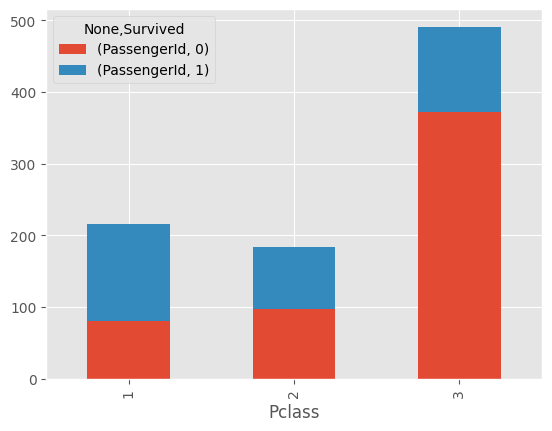

In [27]:
pclass_df.plot.bar(stacked=True)

In [28]:
# これだとだめ
pclass_df_long

PassengerId
Pclass Survived             
1      0                  80
       1                 136
2      0                  97
       1                  87
3      0                 372
       1                 119

In [29]:
pclass_df_long = pclass_df["PassengerId"].reset_index().melt(
    id_vars="Pclass",      # 固定する列
    value_vars=[0, 1],       # Survived=0,1
    var_name="Survived",     # 新しい列名
    value_name="Count"       # 値
)

fig = px.bar(
    pclass_df_long,
    x="Pclass",
    y="Count",
    color="Survived",
    category_orders={"Survived": [0, 1]},  # 下:1 → 上:0
    color_discrete_map={1: "blue", 0: "red"},  # 色指定（任意）
    barmode="stack"
)
fig.show("browser")

In [30]:
pclass_df_long

,Pclass,Survived,Count
0,1,0,80
1,2,0,97
2,3,0,372
3,1,1,136
4,2,1,87
5,3,1,119


#### 2.3.4.年齢(Age)ごとにsurvivalを可視化

ageは比例尺度で連続値なのでビニング（値を並べ一定の数で分割）する

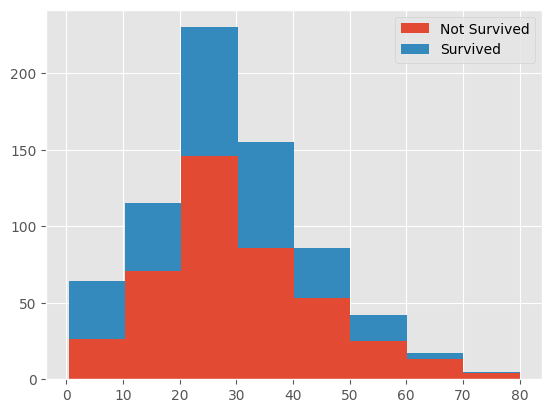

In [31]:
plt.hist(
    (
        train_df[train_df["Survived"] == 0]["Age"].values,
        train_df[train_df["Survived"] == 1]["Age"].values
    ),
    histtype="barstacked",
    bins=8,
    label=["Not Survived", "Survived"],
)

plt.legend()

In [32]:
# # seaborn
# sns.histplot(
#     data=train_df,
#     x="Age",
#     hue="Survived",         # Survivedごとに色分け
#     hue_order=[1, 0],   # 先に1、その上に0を積む
#     multiple="stack",       # 積み上げ
#     bins=8,
#     palette={0:"red", 1:"blue"},
#     edgecolor="black"
# )
# plt.legend(title="Survived", labels=["Not Survived", "Survived"])
# plt.show()

# # plotly
# fig = px.histogram(
#     train_df.dropna(subset=["Age"]),
#     x="Age",
#     color="Survived",
#     barmode="stack",
#     color_discrete_map={0: "red", 1: "blue"},
#     category_orders={"Survived": [0, 1]},
# )

# # ビンの開始・終了・幅を固定（0–80 を 10刻み）
# fig.update_traces(xbins=dict(start=0, end=80, size=10))
# # 軸も合わせておくと見やすい（任意）
# fig.update_xaxes(range=[0, 80], dtick=10)

# # 凡例のラベルを変更
# fig.for_each_trace(
#     lambda t: t.update(name="Not Survived" if t.name == "0" else "Survived")
# )

# fig.show()


### 2.4.カテゴリカル変数のエンコーディング  
>NOTE:数値データには２種類ある
- 質的変数（質的な性質を表す変数）   
  - 名義尺度(Nominal scale)：カテゴリ間に優劣や順序はない（性別，血液型，地域など）→One Hot Encoding（```pd.get_dummies(df)```の利用）
  - 順序尺度(Ordinal scale)：順序に意味がある（階級，レベル，満足度など）→Label Encoding（```sklearn```の```LabelEncoder```の利用）
- 量的変数（数値として意味がある・数値の間隔に意味がある変数）   
  - 間隔尺度(Interval scale)：値の大小＋差（間隔）に意味があり目盛りが等間隔のもの（気温，年号など）   
    ※気温20度は10度の2倍「暑い」ではない
  - 比例尺度(Ratio scale)：値の大小＋差（間隔）＋**比率**に意味があり絶対0が存在する（0=「存在しない」の意味）（身長，体重，年齢，売上，人数，料金など）   
    ※体重60kgは30kgの2倍重い

※量的変数はスケーリングやビニング，特徴量エンジニアリングを行う

#### 2.4.1.カテゴリ変数のSexとEmbarkedをOne Hot Encoding   
Name，Ticket，Cabinはuniqueが多すぎるので使用しない

In [33]:
print("Nameのユニーク数:", train_df["Name"].nunique())
print("Ticketのユニーク数:", train_df["Ticket"].nunique())
print("Cabinのユニーク数:", train_df["Cabin"].nunique())

Nameのユニーク数: 891
Ticketのユニーク数: 681
Cabinのユニーク数: 147


In [34]:
# Name, Sex, Ticket, Cabin, Embarkedは質的変数（カテゴリ変数）
# SexとEmbarkedをone hot encoding
train_df_2 = train_df.copy()
train_df_2 = pd.get_dummies(train_df_2, columns=["Sex"], drop_first=True) # 男性を1、女性を0に変換
train_df_2 = pd.get_dummies(train_df_2, columns=["Embarked"], drop_first=False) # ３種類あるのでdrop_first=False
train_df_2.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,True,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,True,False,False,True


#### 2.4.2.相関行列を作成

In [35]:
train_df_2_corr = train_df_2.corr(numeric_only=True)
train_df_2_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.081720
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.166603
Sex_male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.125722
Embarked_C,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.778359
Embarked_Q,-0.033606,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.496624


<Axes: >

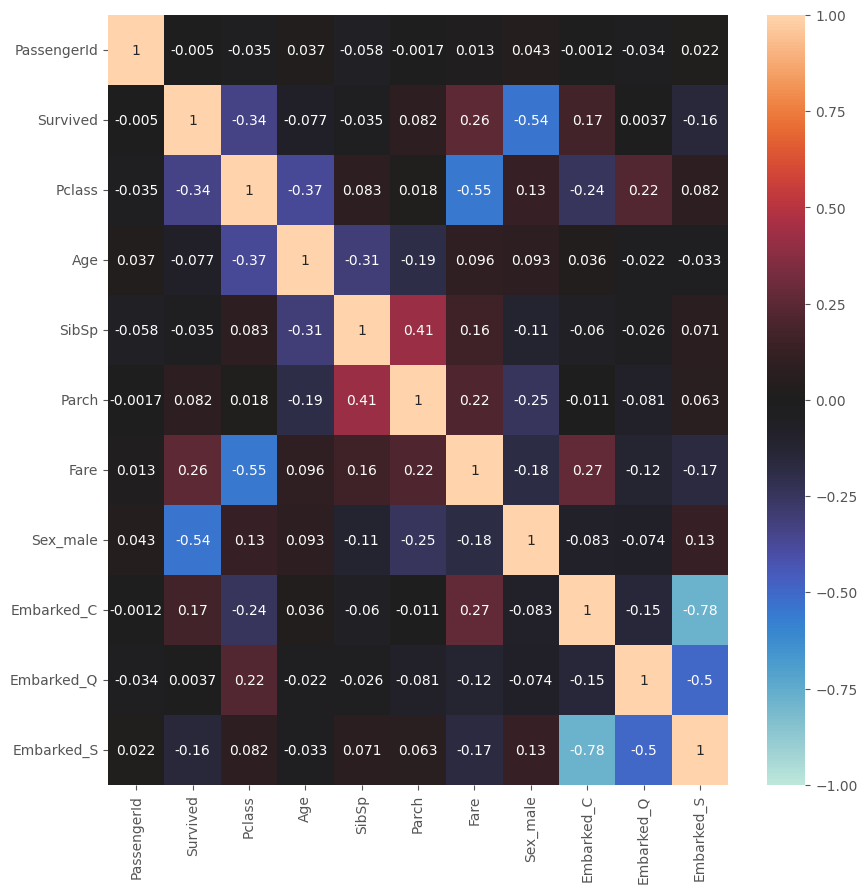

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df_2_corr, vmax=1, vmin=-1, center=0, annot=True)

## 3.前処理

### 3.1.学習データとテストデータを結合(concat)

In [37]:
all_df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 3.2.欠損値の補間

| Column      | Missing Values |
|-------------|----------------|
| PassengerId | 0              |
| Survived    | 418            |
| Pclass      | 0              |
| Name        | 0              |
| Sex         | 0              |
| Age         | 263            |
| SibSp       | 0              |
| Parch       | 0              |
| Ticket      | 0              |
| Fare        | 1              |
| Cabin       | 1014           |
| Embarked    | 2              |


In [38]:
all_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

#### 3.2.1.FareをPclassグループの平均値で埋める

In [39]:
Fare_mean = all_df[["Pclass","Fare"]].groupby("Pclass").mean().reset_index()
Fare_mean.columns = ["Pclass","Fare_mean"]
Fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


Pclassをキーにall_dfとFare_meanを結合   

In [40]:
all_df = all_df.merge(Fare_mean, on="Pclass", how="left")
all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_mean
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,13.302889
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,87.508992
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,13.302889
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,87.508992
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,13.302889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,13.302889
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,87.508992
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,13.302889
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,13.302889


In [41]:
all_df = all_df.drop("Fare_mean",axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


#### 3.2.2.AgeをNameの敬称（例：Mr., Miss.など）に注目して補間

##### 3.2.2.1.Nameを","区切りで分けてhonorific列を作成

In [42]:
all_df["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [43]:
# n:最大分割回数
name_df = all_df["Name"].str.split("[,.]", n=2, expand=True) # expand=Falseだとリストのまま
name_df.columns = ["family_name", "honorific", "first_name"]
name_df.head()

,family_name,honorific,first_name
0,Braund,Mr,Owen Harris
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss,Laina
3,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,Allen,Mr,William Henry


In [44]:
name_df["family_name"] =name_df["family_name"].str.strip()
name_df["honorific"] =name_df["honorific"].str.strip()
name_df["first_name"] =name_df["first_name"].str.strip()
name_df["honorific"].value_counts()

honorific
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

all_dfとname_dfを横に結合

In [45]:
all_df = pd.concat([all_df, name_df], axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,first_name
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick


##### 3.2.2.2.honorificごとに年齢の分布を箱ひげ図（boxplot）で確認

>##### NOTE:Mrs>Miss, Mr>Master

/var/folders/73/2f5c10f1673_2g10_4f7h5qm0000gn/T/ipykernel_71070/38690440.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='honorific', ylabel='Age'>

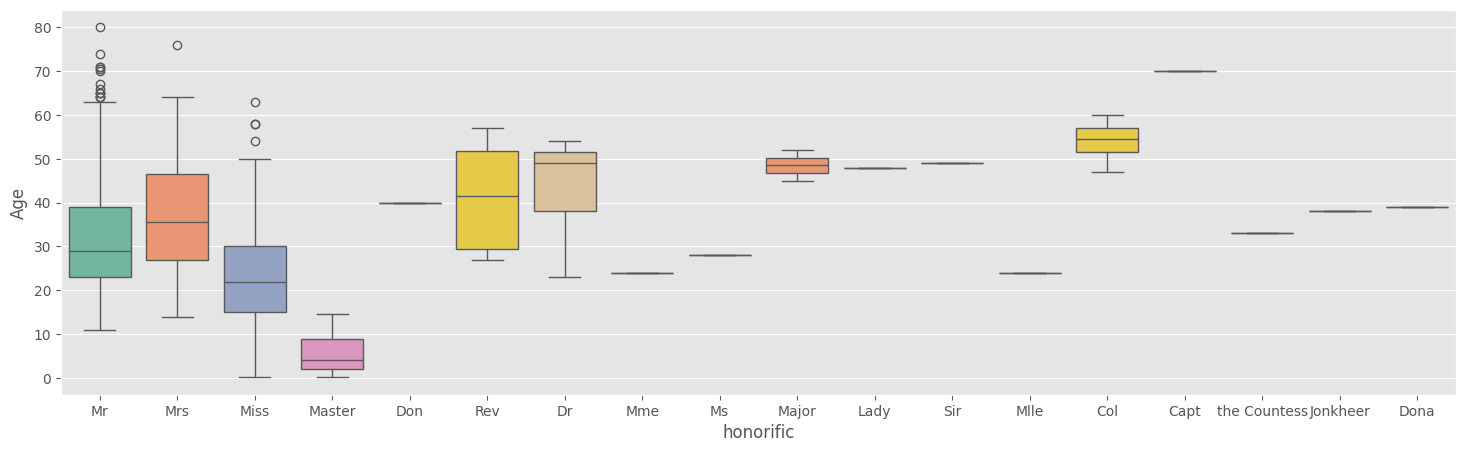

In [46]:
plt.figure(figsize=(18, 5))
sns.boxplot(x="honorific", y="Age", data=all_df,  palette="Set2")

In [47]:
all_df[["Age","honorific"]].groupby("honorific").mean()

,Age
honorific,
Capt,70.000000
Col,54.000000
Don,40.000000
Dona,39.000000
Dr,43.571429
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,5.482642


##### 3.2.2.3.honorificごとにsurvivalを可視化

In [48]:
train_df = pd.concat([train_df,name_df[0:len(train_df)].reset_index(drop=True)],axis=1)
test_df = pd.concat([test_df,name_df[len(train_df):].reset_index(drop=True)],axis=1)

<Axes: xlabel='honorific'>

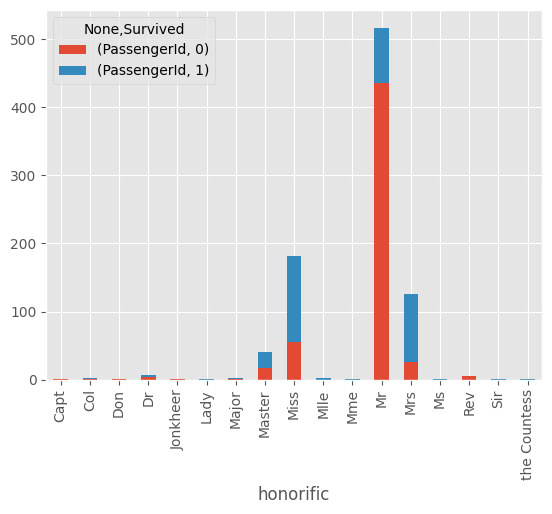

In [49]:
honorific_df = train_df[["honorific","Survived","PassengerId"]].dropna().groupby(["honorific","Survived"]).count().unstack()
honorific_df.plot.bar(stacked=True)

##### 3.2.2.4.honorificごとに性別がどうなっているか確認

In [50]:
sex_honorific_df = train_df[["honorific","Sex", "PassengerId"]].dropna().groupby(["honorific","Sex"]).count().unstack()
sex_honorific_df

PassengerId       
Sex               female   male
honorific                      
Capt                 NaN    1.0
Col                  NaN    2.0
Don                  NaN    1.0
Dr                   1.0    6.0
Jonkheer             NaN    1.0
Lady                 1.0    NaN
Major                NaN    2.0
Master               NaN   40.0
Miss               182.0    NaN
Mlle                 2.0    NaN
Mme                  1.0    NaN
Mr                   NaN  517.0
Mrs                125.0    NaN
Ms                   1.0    NaN
Rev                  NaN    6.0
Sir                  NaN    1.0
the Countess         1.0    NaN

<Axes: xlabel='honorific'>

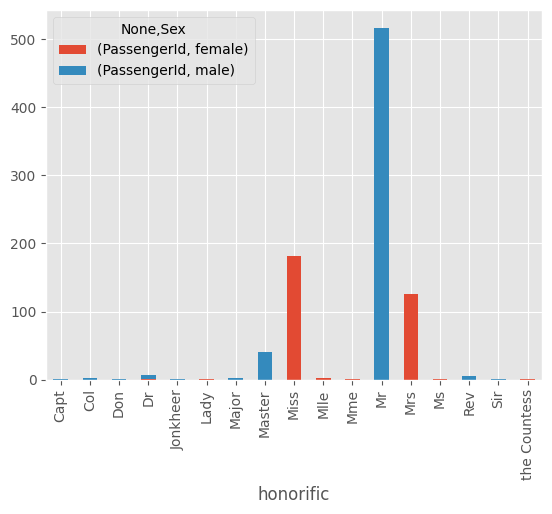

In [51]:
sex_honorific_df.plot.bar(stacked=True)

##### 3.2.2.5.Ageの欠損値をhonorificごとの平均年齢で補完   
※中央値でも良いか？

In [52]:
# 平均値
honorific_age_mean = train_df[["honorific","Age"]].dropna().groupby(["honorific"]).mean().reset_index()
honorific_age_mean.columns = ["honorific","honorific_Age_mean"]
honorific_age_mean

# # 中央値でも良いか？
# honorific_age_median = train_df[["honorific","Age"]].dropna().groupby(["honorific"]).median().reset_index()
# honorific_age_median.columns = ["honorific","honorific_Age_median"]
# honorific_age_median

,honorific,honorific_Age_mean
0,Capt,70.000000
1,Col,58.000000
2,Don,40.000000
3,Dr,42.000000
4,Jonkheer,38.000000
5,Lady,48.000000
6,Major,48.500000
7,Master,4.574167
8,Miss,21.773973
9,Mlle,24.000000


In [53]:
all_df = all_df.merge(honorific_age_mean, on="honorific", how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age_mean"]
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,first_name,honorific_Age_mean
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,32.368090
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),35.898148
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,21.773973
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel),35.898148
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry,32.368090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,32.368090,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf,32.368090
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina,NaN
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen,32.368090
1307,1308,NaN,3,"Ware, Mr. Frederick",male,32.368090,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick,32.368090


In [54]:
all_df = all_df.drop("honorific_Age_mean",axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,first_name
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,32.368090,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen
1307,1308,NaN,3,"Ware, Mr. Frederick",male,32.368090,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick


#### 3.2.3.Embarkedを一番多いEmbarkedの値に注目して補完

In [55]:
embarked_df = all_df[["PassengerId","Embarked"]].dropna().groupby(by=["Embarked"]).count()
print(embarked_df)
print(all_df["Embarked"].mode()[0])

all_df.loc[(all_df["Embarked"].isnull()), "Embarked"] = all_df["Embarked"].mode()[0]
all_df

          PassengerId
Embarked             
C                 270
Q                 123
S                 914
S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,first_name
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,32.368090,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen
1307,1308,NaN,3,"Ware, Mr. Frederick",male,32.368090,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick


## 4.特徴量エンジニアリング

### 4.1.SibSpとParchを用いて家族に関する特徴量を追加→alone

家族人数を計算

In [56]:
all_df["family_num"] = all_df["SibSp"] + all_df["Parch"] # 0が家族なし
all_df["family_num"].value_counts()

family_num
0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: count, dtype: int64

aloneを特徴量として追加

In [57]:
all_df.loc[all_df["family_num"] == 0, "alone"] = 1
all_df["alone"].fillna(0, inplace=True)
all_df

/var/folders/73/2f5c10f1673_2g10_4f7h5qm0000gn/T/ipykernel_71070/3802983514.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,first_name,family_num,alone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,1,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),1,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel),1,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,32.368090,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf,0,1.0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina,0,1.0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen,0,1.0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,32.368090,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick,0,1.0


### 4.2.不要な変数を削除して機械学習に使用する特徴量のみを残す

- 説明変数：```Pclass, Sex, Age, SibSp, Parch, Embarked, honorific, family_num, alone```
- 目的変数：```Survived```

In [58]:
all_df = all_df.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin","family_name", "first_name"], axis=1)
all_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,honorific,family_num,alone
0,0.0,3,male,22.0,1,0,S,Mr,1,0.0
1,1.0,1,female,38.0,1,0,C,Mrs,1,0.0
2,1.0,3,female,26.0,0,0,S,Miss,0,1.0
3,1.0,1,female,35.0,1,0,S,Mrs,1,0.0
4,0.0,3,male,35.0,0,0,S,Mr,0,1.0


### 4.3.カテゴリ変数をエンコーディング

- SexとEmbarkedは4.2.1.と同様
- honorificはMr, Miss, Mrs, Master, otherの5種類にする

In [59]:
category_cols = all_df.columns[all_df.dtypes == "object"]
print(category_cols)

Index(['Sex', 'Embarked', 'honorific'], dtype='object')


In [60]:
all_df.loc[~((all_df["honorific"] =="Mr") |
    (all_df["honorific"] =="Miss") |
    (all_df["honorific"] =="Mrs") |
    (all_df["honorific"] =="Master")), "honorific"] = "other"
all_df["honorific"].value_counts()

honorific
Mr        757
Miss      260
Mrs       197
Master     61
other      34
Name: count, dtype: int64

In [61]:
# SexとEmbarkedをone hot encoding
all_df = all_df.copy()
all_df = pd.get_dummies(all_df, columns=["Sex"], drop_first=True) # 男性を1、女性を0に変換
all_df = pd.get_dummies(all_df, columns=["Embarked"], drop_first=False) # ３種類あるのでdrop_first=False
all_df = pd.get_dummies(all_df, columns=["honorific"], drop_first=False) # 5種類あるのでdrop_first=False
all_df.head()

,Survived,Pclass,Age,SibSp,Parch,family_num,alone,Sex_male,Embarked_C,Embarked_Q,Embarked_S,honorific_Master,honorific_Miss,honorific_Mr,honorific_Mrs,honorific_other
0,0.0,3,22.0,1,0,1,0.0,True,False,False,True,False,False,True,False,False
1,1.0,1,38.0,1,0,1,0.0,False,True,False,False,False,False,False,True,False
2,1.0,3,26.0,0,0,0,1.0,False,False,False,True,False,True,False,False,False
3,1.0,1,35.0,1,0,1,0.0,False,False,False,True,False,False,False,True,False
4,0.0,3,35.0,0,0,0,1.0,True,False,False,True,False,False,True,False,False


>##### NOTE:ラベルエンコーディングでも良い
```python
for cat in categories:
    le = LabelEncoder()
    print(cat)
    if all_df[cat].dtypes == "object":    
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])
```

boolをintに変換

In [62]:
# bool列だけ抽出
bool_cols = all_df.select_dtypes(include="bool").columns
all_df[bool_cols] = all_df[bool_cols].astype("int64")
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    float64
 1   Pclass            1309 non-null   int64  
 2   Age               1309 non-null   float64
 3   SibSp             1309 non-null   int64  
 4   Parch             1309 non-null   int64  
 5   family_num        1309 non-null   int64  
 6   alone             1309 non-null   float64
 7   Sex_male          1309 non-null   int64  
 8   Embarked_C        1309 non-null   int64  
 9   Embarked_Q        1309 non-null   int64  
 10  Embarked_S        1309 non-null   int64  
 11  honorific_Master  1309 non-null   int64  
 12  honorific_Miss    1309 non-null   int64  
 13  honorific_Mr      1309 non-null   int64  
 14  honorific_Mrs     1309 non-null   int64  
 15  honorific_other   1309 non-null   int64  
dtypes: float64(3), int64(13)
memory usage: 163

### 4.4.学習データとテストデータに分割

In [63]:
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1)
train_Y = all_df[~all_df["Survived"].isnull()]["Survived"]
test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

In [64]:
print(train_X.head())

   Pclass   Age  SibSp  Parch  family_num  alone  Sex_male  Embarked_C  \
0       3  22.0      1      0           1    0.0         1           0   
1       1  38.0      1      0           1    0.0         0           1   
2       3  26.0      0      0           0    1.0         0           0   
3       1  35.0      1      0           1    0.0         0           0   
4       3  35.0      0      0           0    1.0         1           0   

   Embarked_Q  Embarked_S  honorific_Master  honorific_Miss  honorific_Mr  \
0           0           1                 0               0             1   
1           0           0                 0               0             0   
2           0           1                 0               1             0   
3           0           1                 0               0             0   
4           0           1                 0               0             1   

   honorific_Mrs  honorific_other  
0              0                0  
1              1    

## 5.機械学習モデル作成

LightGBM（Light Gradient Boosting Machine）を使用
- 数値だけど実態はカテゴリの列は```categorical_feature```にリストとして代入
- LightGBMはNaNをそのまま扱える（欠損分岐を勝手に作る）

### 5.1.初期値でデータ分割から学習・テストデータでの評価まで行う

train:valid=4:1に分割

- train_X.shape():(891, 15)
- train_Y.shape():(891,)
- X_train.shape():(713, 15)
- X_valid.shape():(178, 15)
- y_train.shape():(713,)
- y_valid.shape():(178,)
- test_X.shape():(418, 15)

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)
categories = ["Pclass"]

In [133]:
print(train_X.shape)
print(train_Y.shape)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(test_X.shape)

(891, 15)
(891,)
(713, 15)
(178, 15)
(713,)
(178,)
(418, 15)


In [66]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid,  categorical_feature=categories, reference=lgb_train)
# lgb_eval に reference=lgb_train を指定すると、メモリ効率よく学習可能

ハイパーパラメータ設定

In [67]:
lgbm_params = {
    "objective":"binary",        
    "random_seed":42
}

モデル学習

In [68]:
model_lgb = lgb.train(
    params=lgbm_params,
    train_set=lgb_train,
    valid_sets=[lgb_eval],
    num_boost_round=100, # 最大100回学習
    callbacks=[
        early_stopping(stopping_rounds=20),   # 早期終了
        log_evaluation(period=10)             # 10イテごとにログ表示
    ]
)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

特徴量重要度の可視化

'Pclass', 'Age', 'SibSp', 'Parch', 'family_num', 'alone', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'honorific_Master', 'honorific_Miss', 'honorific_Mr', 'honorific_Mrs', 'honorific_other'

[110 483  30  12  47   8  27  23  22  45   1  17  24  13  11]


<Axes: >

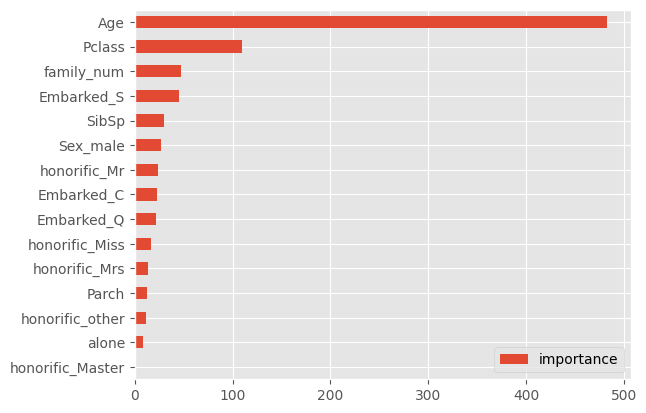

In [ ]:
print(model_lgb.feature_importance())
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending =True)
importance.plot.barh()

予測と評価

In [70]:
# model_lgb.best_iterationが最適なイテレーション数
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
accuracy_score(y_valid, np.round(y_pred))

0.8156424581005587

### 5.2.別のパラメータで学習・評価

In [71]:
lgbm_params = {
    "objective":"binary",
    "max_bin":331,
    "num_leaves": 20,
    "min_data_in_leaf": 57,
    "random_seed":42
}

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)

model_lgb = lgb.train(
    params=lgbm_params,
    train_set=lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=20), 
        log_evaluation(period=10)             
    ]
)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [72]:
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
accuracy_score(y_valid, np.round(y_pred))

0.8100558659217877

### 5.3.クロスバリデーションの実施

In [73]:
folds = 3
kf = KFold(n_splits=folds)

In [74]:
models = []

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)    
    
    model_lgb = lgb.train(
        params=lgbm_params,
        train_set=lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=100,
        callbacks=[
            early_stopping(stopping_rounds=20), 
            log_evaluation(period=10)             
        ]
    )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    print(accuracy_score(y_valid, np.round(y_pred)))
    
    models.append(model_lgb)

[LightGBM] [Info] Number of positive: 236, number of negative: 358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397306 -> initscore=-0.416701
[LightGBM] [Info] Start training from score -0.416701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [75]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [76]:
# 予測値の平均を最終的な予測値とする
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [77]:
preds_int = (preds_mean > 0.5).astype(int)

### 5.4.提出用csvの作成

In [78]:
submission = gender_submission_df.copy()
submission["Survived"] = preds_int
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
submission.to_csv("./output/titanic_submit20250824.csv", index=False)

## 6.Optunaによるハイパーパラメータチューニング

- stratifyを指定することで学習データ・検証データそれぞれでラベル分布が元データと同じ比率になるように分割
- shuffle=Falseだとデータ順のまま分割（注：時系列データは未来を予測するのに過去と未来を混ぜうるのはリークになるためshuffle=Falseにする）

パラメータの探索→```study.best_params```に最適パラメータが保存される

In [103]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=42
)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",     # 早期終了の監視用（最小化）
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "min_data_in_leaf": trial.suggest_int("min_child_samples", 5, 100),  # = min_child_samples
        "feature_fraction": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("subsample", 0.5, 1.0),
        "bagging_freq": 1,
        "lambda_l1": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "seed": 42,
    }

    accuracys = []  
    for tr_idx, va_idx in kf.split(train_X, train_Y):
        X_tr, X_va = train_X.iloc[tr_idx], train_X.iloc[va_idx]
        y_tr, y_va = train_Y.iloc[tr_idx], train_Y.iloc[va_idx]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categories, free_raw_data=False)
        lgb_eval  = lgb.Dataset(X_va, y_va, categorical_feature=categories, reference=lgb_train, free_raw_data=False)

        model = lgb.train(
            params=params,
            train_set=lgb_train,
            valid_sets=[lgb_eval],
            num_boost_round=3000,
            callbacks=[early_stopping(100, verbose=False)]  # v4系
        )

        proba = model.predict(X_va, num_iteration=model.best_iteration)
        pred  = (proba >= 0.5).astype(int)
        accuracys.append(accuracy_score(y_va, pred))

    return float(np.mean(accuracys))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best accuracy (CV mean):", study.best_value)
print("Best params:", study.best_params)


[I 2025-08-24 20:32:32,596] A new study created in memory with name: no-name-ed8a29ac-e9f2-4370-8637-346b9046e82d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-24 20:32:34,697] Trial 0 finished with value: 0.8204318624066286 and parameters: {'learning_rate': 0.03636852312616335, 'num_leaves': 23, 'min_child_samples': 60, 'colsample_bytree': 0.9948201200403465, 'subsample': 0.5870960012159239, 'reg_alpha': 0.0005300918740083941, 'reg_lambda': 0.00014583901775289698}. Best is trial 0 with value: 0.8204318624066286.
[I 2025-08-24 20:32:56,623] Trial 1 finished with value: 0.8339087314041805 and parameters: {'learning_rate': 0.0015161725956717817, 'num_leaves': 116, 'min_child_samples': 20, 'colsample_bytree': 0.6142183750686039, 'subsample': 0.865318563493064, 'reg_alpha': 0.8275138787892214, 'reg_lambda': 0.33096095560243466}. Best is trial 1 with value: 0.8339087314041805.
[I 2025-08-24 20:32:59,873] Trial 2 finished with value: 0.8294143493817085 and parameters: {'learning_rate': 0.017487442293887302, 'num_leaves': 149, 'min_child_samples': 79, 'colsample_bytree': 0.6551767930908843, 'subsample': 0.9452848082002989, 'reg_alpha': 0.

見つけた最適なパラメータで実際にKFoldモデルを複数作成・評価・保存

In [104]:
models = []
acc_list = []

for fold, (train_index, val_index) in enumerate(kf.split(train_X, train_Y), 1):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories, free_raw_data=False)
    lgb_eval  = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train, free_raw_data=False)

    model_lgb = lgb.train(
        params=study.best_params,
        train_set=lgb_train,
        valid_sets=[lgb_eval],
        num_boost_round=3000,
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(period=100),
        ]
    )

    y_pred_proba = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    acc = accuracy_score(y_valid, y_pred)
    print(f"Fold {fold} ACC:", acc)

    acc_list.append(acc)
    models.append(model_lgb)

print("CV ACC (mean):", np.mean(acc_list))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.190705
[200]	valid_0's l2: 0.163493
[300]	valid_0's l2: 0.146739
[400]	valid_0's l2: 0.136641
[500]	valid_0's l2: 0.130338
[600]	valid_0's l2: 0.126461
[700]	valid_0's l2: 0.124173
[800]	valid_0's l2: 0.121921
[900]	valid_0's l2: 0.120909
[1000]	valid_0's l2: 0.120048
[1100]	valid_0's l2: 0.119474
[1200]	valid_0's l2: 0.119108
[1300]	valid_0's l2: 0.118892
[1400]	valid_0's l2: 0.1188
[1500]	valid_0's l2: 0.1188
Early stopping, best iteration is:
[1429]	valid_0's l2: 0.118739
Fold 1 ACC: 0.8212290502793296
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.192202
[200]	valid_0's l2: 0.166389
[300]	valid_0's l2: 0.151078
[400]	valid_0's l2: 0.14267
[500]	valid_0's l2: 0.13633
[600]	valid_0's l2: 0.132589
[700]	valid_0's l2: 0.130689
[800]	valid_0's l2: 0.129293
[900]	valid_0's l2: 0.128588
[1000]	valid_0's l2: 0.128163
[1100]	valid_0's l2: 0.128093
Early stopping, best ite

In [ ]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)
preds_int = (preds_mean > 0.5).astype(int)
submission_2 = gender_submission_df.copy()
submission_2["Survived"] = preds_int
submission_2.to_csv("./output/titanic_submit20250824_2.csv", index=False)
submission_2

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## 7.SHAP値を可視化

全データで再学習した最終モデルを作成

In [ ]:
# 全データで再学習
lgb_train = lgb.Dataset(train_X, train_Y, categorical_feature=categories)
final_model = lgb.train(
    params=study.best_params, # Optunaで見つけた最適パラメータ
    train_set=lgb_train,
    num_boost_round=3000
)

Summary Plotの作成
- 縦の順序：平均的に影響が大きい特徴量ほど上
  - 例：honorific_Mr・Pclass・Sex_male・Age が強い。
- 横方向（SHAP value の符号）：
  - 右（＋）：生存（クラス1）の確率を上げる寄与
  - 左（−）：生存確率を下げる寄与
- 色：その点の 特徴量の値。ピンク=高い、青=低い。
  - 注：One-Hot列は 0/1 なので、ピンク=1、青=0 と解釈。
  - 例：Sex_male はピンク（男）が左へ寄りやすい＝生存確率を下げる。
- 点の幅（散らばり）：その特徴量の影響の大きさのばらつき。外れ値があると点が横に長く伸びます。

/var/folders/73/2f5c10f1673_2g10_4f7h5qm0000gn/T/ipykernel_71070/434422642.py:8: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



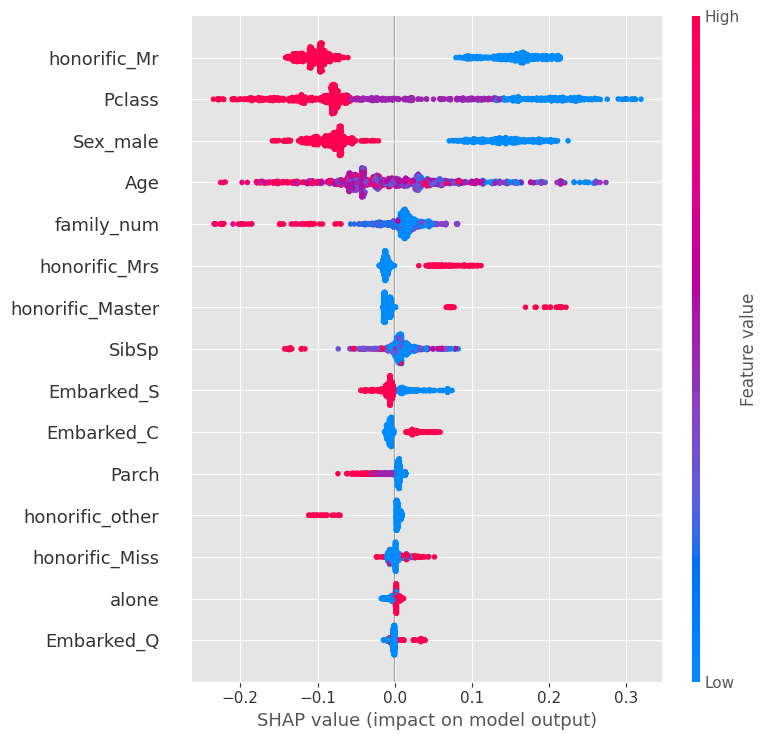

In [ ]:
# 1. TreeExplainerを作成
explainer = shap.TreeExplainer(final_model)  # LightGBMの学習済みモデル
# 2. SHAP値を計算
shap_values = explainer.shap_values(train_X)
# 3. 可視化
shap.summary_plot(shap_values, train_X)  # 全体の特徴量重要度（平均寄与度）

## 8.XGBoostの利用

In [118]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",      # 早期終了の監視用（最小化）
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
    }

    accuracys = []
    for tr_idx, va_idx in kf.split(train_X, train_Y):
        X_tr, X_va = train_X.iloc[tr_idx], train_X.iloc[va_idx]
        y_tr, y_va = train_Y.iloc[tr_idx], train_Y.iloc[va_idx]

        xgb_train = xgb.DMatrix(X_tr, label=y_tr)
        xgb_valid = xgb.DMatrix(X_va, label=y_va)

        model_xgb = xgb.train(
            params=params,
            dtrain=xgb_train,
            num_boost_round=3000,
            evals=[(xgb_valid, "valid")],
            early_stopping_rounds=100,      # XGBoostはこれが使える
            verbose_eval=10
        )

        y_pred = model_xgb.predict(xgb_valid, iteration_range=(0, model_xgb.best_iteration+1))
        pred = (y_pred >= 0.5).astype(int)
        accuracys.append(accuracy_score(y_va, pred))

    return float(np.mean(accuracys))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best accuracy (CV mean):", study.best_value)
print("Best params:", study.best_params)


[I 2025-08-24 21:19:15,262] A new study created in memory with name: no-name-dcd06c05-2c2f-45cf-9d0f-db16103a7070


  0%|          | 0/50 [00:00<?, ?it/s]

[0]	valid-logloss:0.66311
[10]	valid-logloss:0.63166
[20]	valid-logloss:0.60446
[30]	valid-logloss:0.58162
[40]	valid-logloss:0.56303
[50]	valid-logloss:0.54677
[60]	valid-logloss:0.53249
[70]	valid-logloss:0.52031
[80]	valid-logloss:0.50837
[90]	valid-logloss:0.49858
[100]	valid-logloss:0.49063
[110]	valid-logloss:0.48258
[120]	valid-logloss:0.47578
[130]	valid-logloss:0.47007
[140]	valid-logloss:0.46564
[150]	valid-logloss:0.46188
[160]	valid-logloss:0.45887
[170]	valid-logloss:0.45512
[180]	valid-logloss:0.45235
[190]	valid-logloss:0.44956
[200]	valid-logloss:0.44714
[210]	valid-logloss:0.44509
[220]	valid-logloss:0.44329
[230]	valid-logloss:0.44199
[240]	valid-logloss:0.44033
[250]	valid-logloss:0.43949
[260]	valid-logloss:0.43876
[270]	valid-logloss:0.43814
[280]	valid-logloss:0.43736
[290]	valid-logloss:0.43643
[300]	valid-logloss:0.43562
[310]	valid-logloss:0.43508
[320]	valid-logloss:0.43471
[330]	valid-logloss:0.43395
[340]	valid-logloss:0.43339
[350]	valid-logloss:0.43319
[36

In [119]:
models = []
acc_list = []

for fold, (train_index, val_index) in enumerate(kf.split(train_X, train_Y), 1):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_valid = xgb.DMatrix(X_valid, label=y_valid)

    model_xgb = xgb.train(
        params=study.best_params,
        dtrain=xgb_train,
        num_boost_round=3000,
        evals=[(xgb_valid, "valid")],
        early_stopping_rounds=100,
        verbose_eval=10
    )

    y_pred_proba = model_xgb.predict(xgb_valid, iteration_range=(0, model_xgb.best_iteration+1))
    y_pred = (y_pred_proba >= 0.5).astype(int)
    acc = accuracy_score(y_valid, y_pred)
    print(f"Fold {fold} ACC:", acc)

    acc_list.append(acc)
    models.append(model_xgb)

print("CV ACC (mean):", np.mean(acc_list))

[0]	valid-rmse:0.47096
[10]	valid-rmse:0.39981
[20]	valid-rmse:0.38327
[30]	valid-rmse:0.38051
[40]	valid-rmse:0.38031
[50]	valid-rmse:0.38030
[60]	valid-rmse:0.37907
[70]	valid-rmse:0.37801
[80]	valid-rmse:0.37680
[90]	valid-rmse:0.37678
[100]	valid-rmse:0.37670
[110]	valid-rmse:0.37583
[120]	valid-rmse:0.37588
[130]	valid-rmse:0.37585
[140]	valid-rmse:0.37596
[150]	valid-rmse:0.37599
[160]	valid-rmse:0.37600
[170]	valid-rmse:0.37491
[180]	valid-rmse:0.37488
[190]	valid-rmse:0.37480
[200]	valid-rmse:0.37498
[210]	valid-rmse:0.37506
[220]	valid-rmse:0.37495
[230]	valid-rmse:0.37484
[240]	valid-rmse:0.37477
[250]	valid-rmse:0.37481
[260]	valid-rmse:0.37486
[270]	valid-rmse:0.37487
[280]	valid-rmse:0.37479
[290]	valid-rmse:0.37492
[300]	valid-rmse:0.37483
[310]	valid-rmse:0.37474
[320]	valid-rmse:0.37483
[330]	valid-rmse:0.37481
[340]	valid-rmse:0.37489
[350]	valid-rmse:0.37497
[360]	valid-rmse:0.37490
[370]	valid-rmse:0.37495
[380]	valid-rmse:0.37490
[390]	valid-rmse:0.37473
[400]	valid

XGBoost の model.predict() は DataFrame ではなく DMatrix を受け取る

In [ ]:
preds = []

for model in models:
    pred = model.predict(xgb.DMatrix(test_X))
    preds.append(pred)

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)
preds_int = (preds_mean > 0.5).astype(int)
submission_3 = gender_submission_df.copy()
submission_3["Survived"] = preds_int
submission_3.to_csv("./output/titanic_submit20250824_3.csv", index=False)
submission_3

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## 9.RandomForestの利用

In [130]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "n_jobs": -1,
        "random_state": 42,
    }

    accuracys = []
    for tr_idx, va_idx in kf.split(train_X, train_Y):
        X_tr, X_va = train_X.iloc[tr_idx], train_X.iloc[va_idx]
        y_tr, y_va = train_Y.iloc[tr_idx], train_Y.iloc[va_idx]

        model_rf = RandomForestClassifier(**params)
        model_rf.fit(X_tr, y_tr)

        y_pred = model_rf.predict(X_va)
        accuracys.append(accuracy_score(y_va, y_pred))

    return float(np.mean(accuracys))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best accuracy (CV mean):", study.best_value)
print("Best params:", study.best_params)


[I 2025-08-24 21:39:04,384] A new study created in memory with name: no-name-d7d3a321-7c7d-429b-854f-b695b997b99f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-24 21:39:06,310] Trial 0 finished with value: 0.8103257799259305 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.8103257799259305.
[I 2025-08-24 21:39:06,954] Trial 1 finished with value: 0.8249262444291003 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8249262444291003.
[I 2025-08-24 21:39:09,984] Trial 2 finished with value: 0.8080911430544223 and parameters: {'n_estimators': 1000, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8249262444291003.
[I 2025-08-24 21:39:10,834] Trial 3 finished with value: 0.8103132257862029 and parameters: {'n_estimators':

In [131]:
best = {**study.best_params, "n_jobs": -1, "random_state": 42}
models = []
acc_list = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(train_X, train_Y), 1):
    X_tr, X_va = train_X.iloc[tr_idx], train_X.iloc[va_idx]
    y_tr, y_va = train_Y.iloc[tr_idx], train_Y.iloc[va_idx]

    rf = RandomForestClassifier(**best)
    rf.fit(X_tr, y_tr)

    proba_va = rf.predict_proba(X_va)[:,1]
    pred_va  = (proba_va >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred_va)
    print(f"Fold {fold} ACC: {acc:.4f}")

    models.append(rf)
    acc_list.append(acc)

print("CV ACC (mean):", np.mean(acc_list))

Fold 1 ACC: 0.8324
Fold 2 ACC: 0.8146
Fold 3 ACC: 0.8315
Fold 4 ACC: 0.8315
Fold 5 ACC: 0.8539
CV ACC (mean): 0.832772581758835


In [ ]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)
preds_int = (preds_mean > 0.5).astype(int)
submission_4 = gender_submission_df.copy()
submission_4["Survived"] = preds_int
submission_4.to_csv("./output/titanic_submit20250824_4.csv", index=False)
submission_4

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## opt-A.2つのdfの差を比較

In [122]:
def compare_submissions(sub1, sub2, col="Survived"):
    """
    2つの提出DataFrameの指定列を比較し、異なる行のみを返す。
    """
    comparison = sub1.copy()
    comparison[f"{col}_2"] = sub2[col].values
    comparison["Different"] = comparison[col] != comparison[f"{col}_2"]
    return comparison[comparison["Different"]]

In [136]:
print(compare_submissions(submission, submission_2))
print(compare_submissions(submission, submission_3))
print(compare_submissions(submission_2, submission_3))

     PassengerId  Survived  Survived_2  Different
23           915         1           0       True
32           924         0           1       True
33           925         0           1       True
36           928         1           0       True
94           986         1           0       True
118         1010         0           1       True
125         1017         0           1       True
138         1030         0           1       True
157         1049         0           1       True
165         1057         0           1       True
169         1061         0           1       True
192         1084         0           1       True
202         1094         1           0       True
244         1136         0           1       True
268         1160         1           0       True
280         1172         0           1       True
293         1185         1           0       True
354         1246         0           1       True
367         1259         0           1       True


In [138]:
print(compare_submissions(submission_3, submission_4))

     PassengerId  Survived  Survived_2  Different
21           913         0           1       True
64           956         0           1       True
80           972         0           1       True
131         1023         1           0       True
161         1053         0           1       True
192         1084         0           1       True
201         1093         0           1       True
244         1136         0           1       True
281         1173         0           1       True
293         1185         1           0       True
307         1199         0           1       True
339         1231         0           1       True
344         1236         0           1       True
392         1284         0           1       True
417         1309         0           1       True
